<a href="https://colab.research.google.com/github/juanmed/epipolar_geometry/blob/main/Manual_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 76kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenA.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenB.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left01.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right01.jpg
!wget https://raw.githubusercontent.com/juanmed/epipolar_geometry/main/1.png
!wget https://raw.githubusercontent.com/juanmed/epipolar_geometry/main/2.png
!wget https://raw.githubusercontent.com/greenteawarrior/comprobo2014/master/exercises/epipolar_geometry/frame0000.jpg
!wget https://raw.githubusercontent.com/greenteawarrior/comprobo2014/master/exercises/epipolar_geometry/frame0001.jpg
!wget https://raw.githubusercontent.com/greenteawarrior/comprobo2014/master/exercises/epipolar_geometry/correspondences.pickle

In [15]:
import cv2
import pickle
import numpy as np
from matplotlib import pyplot as plt

D = np.array( [0.4047389030456543, -2.626350164413452, 0.00027515311376191676, -5.470857649925165e-05, 1.6036430597305298, 0.285593181848526, -2.4465601444244385, 1.5245165824890137])
K = np.array( [963.1787109375, 0.0, 1020.224365234375, 0.0, 962.905517578125, 779.256591796875, 0.0, 0.0, 1.0]).reshape(3,3)
W = np.array([[0.0, -1.0, 0.0],
			  [1.0, 0.0, 0.0],
			  [0.0, 0.0, 1.0]])

colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)]
pt_num = 0
im1_pts = []
im2_pts = []

def triangulate_points(pt_set1, pt_set2, P, P1):
	my_points = cv2.triangulatePoints(P,P1,pt_set1.T,pt_set2.T)
	projected_points_1 = P.dot(my_points)
	
	# convert to inhomogeneous coordinates
	for i in range(projected_points_1.shape[1]):
		projected_points_1[0,i] /= projected_points_1[2,i]
		projected_points_1[1,i] /= projected_points_1[2,i]
		projected_points_1[2,i] /= projected_points_1[2,i]

	projected_points_2 = P1.dot(my_points)
	# convert to inhomogeneous coordinates
	for i in range(projected_points_2.shape[1]):
		projected_points_2[0,i] /= projected_points_2[2,i]
		projected_points_2[1,i] /= projected_points_2[2,i]
		projected_points_2[2,i] /= projected_points_2[2,i]

	# convert to inhomogeneous coordinates
	for i in range(projected_points_2.shape[1]):
		my_points[0,i] /= my_points[3,i]
		my_points[1,i] /= my_points[3,i]
		my_points[2,i] /= my_points[3,i]
		my_points[3,i] /= my_points[3,i]

	return my_points.T

def test_epipolar(E,pt1,pt2):
	pt1_h = np.zeros((3,1))
	pt2_h = np.zeros((3,1))
	pt1_h[0:2,0] = pt1.T
	pt2_h[0:2,0] = pt2.T
	pt1_h[2] = 1.0
	pt2_h[2] = 1.0
	return pt2_h.T.dot(E).dot(pt1_h)

def test_triangulation(P,pcloud):
	P4x4 = np.eye(4)
	P4x4[0:3,:] = P
	pcloud_3d = pcloud[:,0:3]
	projected = cv2.perspectiveTransform(np.array([pcloud_3d]),P4x4)
	return np.mean(projected[0,:,2]>0.0)

def mouse_event(event,x,y,flag,im):
	if event == cv2.EVENT_FLAG_LBUTTON:
		if x < im.shape[1]/2.0:
			l = F.dot(np.array([x,y,1.0]))
			m = -l[0]/l[1]
			b = -l[2]/l[1]
			# equation of the line is y = m*x+b
			y_for_x_min = m*0.0+b
			y_for_x_max = m*(im.shape[1]/2.0-1)+b
			# plot the epipolar line
			cv2.line(im,(int(im.shape[1]/2.0),int(y_for_x_min)),(int(im.shape[1]-1.0),int(y_for_x_max)),(255,0,0))



In [20]:

im1 = cv2.imread('frame0000.jpg')
im2 = cv2.imread('frame0001.jpg')

with open('correspondences.pickle','rb') as f:
  correspondences = pickle.load(f)
f.close()

im1_pts = np.zeros((len(correspondences[0]),2))
im2_pts = np.zeros((len(correspondences[1]),2))

print (correspondences)

im = np.array(np.hstack((im1,im2)))

# plot the points
for i in range(len(im1_pts)):
  im1_pts[i,0] = correspondences[0][i][0]
  im1_pts[i,1] = correspondences[0][i][1]
  im2_pts[i,0] = correspondences[1][i][0]
  im2_pts[i,1] = correspondences[1][i][1]

  cv2.circle(im,(int(im1_pts[i,0]),int(im1_pts[i,1])),2,(255,0,0),2)
  cv2.circle(im,(int(im2_pts[i,0]+im1.shape[1]),int(im2_pts[i,1])),2,(255,0,0),2)

im1_pts_augmented = np.zeros((1,im1_pts.shape[0],im1_pts.shape[1]))
im1_pts_augmented[0,:,:] = im1_pts
im2_pts_augmented = np.zeros((1,im2_pts.shape[0],im2_pts.shape[1]))
im2_pts_augmented[0,:,:] = im2_pts

im1_pts_ud = cv2.undistortPoints(im1_pts_augmented,K,D)
im2_pts_ud = cv2.undistortPoints(im2_pts_augmented,K,D)
print(len(im1_pts_ud),len(im2_pts_ud))
E, mask = cv2.findFundamentalMat(im1_pts_ud,im2_pts_ud,cv2.FM_RANSAC)

im1_pts_ud = np.reshape(im1_pts_ud,(1,12,2))
im2_pts_ud = np.reshape(im2_pts_ud,(1,12,2))

im1_pts_ud_fixed, im2_pts_ud_fixed = cv2.correctMatches(E, im1_pts_ud, im2_pts_ud)
use_corrected_matches = True
if not(use_corrected_matches):
  im1_pts_ud_fixed = im1_pts_ud
  im2_pts_ud_fixed = im2_pts_ud

epipolar_error = np.zeros((im1_pts_ud_fixed.shape[1],))
for i in range(im1_pts_ud_fixed.shape[1]):
  epipolar_error[i] = test_epipolar(E,im1_pts_ud_fixed[0,i,:],im2_pts_ud_fixed[0,i,:])

F = np.linalg.inv(K.T).dot(E).dot(np.linalg.inv(K))
U, Sigma, V = np.linalg.svd(E)

R1 = U.dot(W).dot(V)
R2 = U.dot(W.T).dot(V)

if np.linalg.det(R1)+1.0 < 10**-8:
  # flip sign of E and recompute everything
  E = -E
  F = np.linalg.inv(K.T).dot(E).dot(np.linalg.inv(K))
  U, Sigma, V = np.linalg.svd(E)

  R1 = U.dot(W).dot(V)
  R2 = U.dot(W.T).dot(V)

t1 = U[:,2]
t2 = -U[:,2]

P = np.array([[1.0,	0.0, 0.0, 0.0],
        [0.0,	1.0, 0.0, 0.0],
        [0.0,	0.0, 1.0, 0.0]]);
P1_possibilities = []
P1_possibilities.append(np.dot(K,np.column_stack((R1,t1))))
P1_possibilities.append(np.dot(K,np.column_stack((R1,t2))))
P1_possibilities.append(np.dot(K,np.column_stack((R2,t1))))
P1_possibilities.append(np.dot(K,np.column_stack((R2,t2))))

pclouds = []
for P1 in P1_possibilities:
  pclouds.append(triangulate_points(im1_pts_ud_fixed, im2_pts_ud_fixed, P, P1))

infront_of_camera = []
for i in range(len(P1_possibilities)):
  infront_of_camera.append(test_triangulation(P,pclouds[i])+test_triangulation(P1_possibilities[i],pclouds[i]))

best_pcloud = pclouds[np.argmax(infront_of_camera)]
# correct offset and normalize
depths = best_pcloud[:,2] - min(best_pcloud[:,2])
depths = depths / max(depths)
print (depths)

for i in range(best_pcloud.shape[0]):
  cv2.circle(im,(int(im1_pts[i,0]),int(im1_pts[i,1])),int(max(1.0,depths[i]*20.0)),(0,255,0),1)

([(75.5, 286.5), (142.5, 328.5), (150.0, 325.0), (168.0, 313.5), (198.5, 308.5), (146.5, 157.5), (534.5, 280.0), (422.0, 205.0), (306.5, 140.0), (296.0, 111.5), (381.0, 44.5), (234.0, 268.5)], [(40.0, 274.5), (86.0, 329.5), (113.5, 322.0), (152.5, 305.5), (193.0, 301.0), (141.0, 142.5), (588.0, 266.0), (431.5, 191.0), (308.5, 124.0), (297.5, 93.0), (390.0, 15.5), (232.5, 258.0)])
12 12
[0.         0.11445428 0.13180941 0.17501472 0.24029088 0.19558536
 1.         0.75831739 0.52717342 0.5113675  0.69260176 0.33324548]


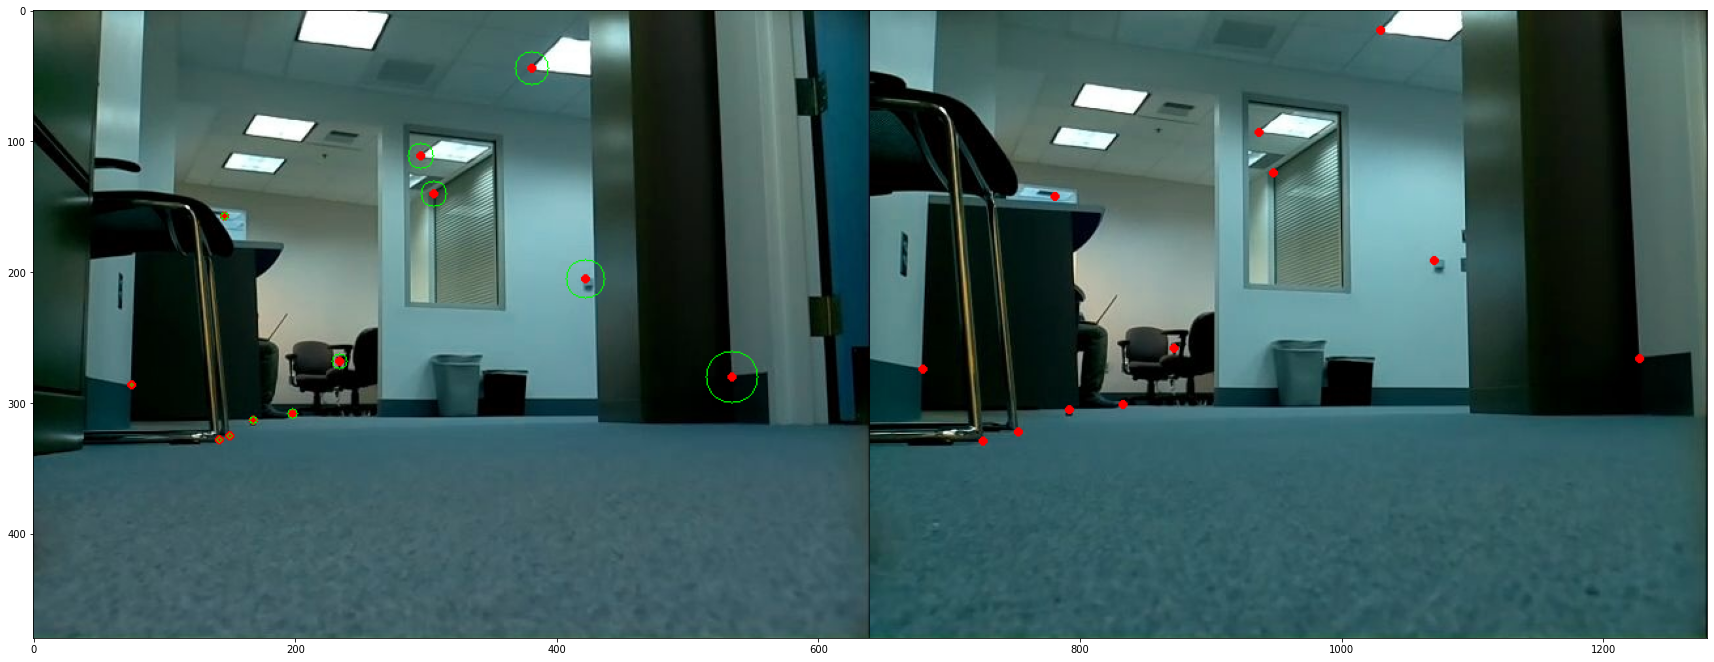

In [21]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(1,1,1)
ax1.imshow(im, cmap="gray")


In [22]:
import pandas as pd
import plotly.express as px
threeD_coords = cv2.convertPointsFromHomogeneous(homogeneous_4d_coords.transpose())
xdata = best_pcloud[:,0]
ydata = best_pcloud[:,1]
zdata = best_pcloud[:,2]
df = pd.DataFrame({'x': xdata, 'y':ydata, 'z':zdata})
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

NameError: ignored

In [18]:
best_pcloud

array([[-0.30243701, -0.55396703,  0.41649677,  1.        ],
       [-0.31778068, -0.550743  ,  0.45583583,  1.        ],
       [-0.31717185, -0.56195952,  0.46390835,  1.        ],
       [-0.308789  , -0.57943933,  0.47359692,  1.        ],
       [-0.30096661, -0.59364186,  0.48865616,  1.        ],
       [-0.22064666, -0.61959804,  0.41381584,  1.        ],
       [-0.16618522, -0.73733931,  0.67064718,  1.        ],
       [-0.16037038, -0.69362347,  0.55047097,  1.        ],
       [-0.1650171 , -0.67174519,  0.47371709,  1.        ],
       [-0.15326176, -0.67519094,  0.46035728,  1.        ],
       [-0.08747104, -0.71599727,  0.47493288,  1.        ],
       [-0.26520739, -0.61760045,  0.48901481,  1.        ]])